# IA353 - Redes Neurais
# EFC3 - Questão 7

# Interpretability
dataset: MNIST

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  Rafael Ito

# 7.1 Libraries and packages

## 7.1.1 Install packages

In [1]:
# install Python libs
!pip install -q         \
    numpy               \
    innvestigate        \
    keras==2.2.4        \
    tensorflow==1.15.0   \
    git+https://github.com/raghakot/keras-vis.git -U
    #keras-vis

     |████████████████████████████████| 14.6MB 211kB/s 
     |████████████████████████████████| 102kB 13.5MB/s 
     |████████████████████████████████| 317kB 53.0MB/s 
     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 3.8MB 45.1MB/s 
     |████████████████████████████████| 512kB 50.4MB/s 
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


## 7.1.2 Import libraries

In [2]:
#-------------------------------------------------
# general
import numpy as np
import sys
import os
import pdb
import subprocess
from collections import Counter
from multiprocessing import cpu_count
#-------------------------------------------------
# interpretability
import keras
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import innvestigate
import matplotlib.pyplot as plt
from vis.visualization import visualize_activation
from vis.utils import utils
#-------------------------------------------------
# random seed generator
os.environ['PYTHONHASHSEED']=str(42)
np.random.seed(42)
#tf.random.set_seed(42)
tf.random.set_random_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

Using TensorFlow backend.


## 7.1.3 Device info

In [3]:
# choose between CPU and GPU
device = tf.device('/cpu:0')
#if tf.config.list_physical_devices('GPU'):
if tf.config.experimental.list_physical_devices('GPU'):
    device = tf.device('/device:GPU:0')
#    device_model = torch.cuda.get_device_name(0)
#    device_memory = torch.cuda.get_device_properties(device).total_memory / 1e9
    device_number = len(tf.config.experimental.list_physical_devices('GPU'))
    #----------------------------
    #from tensorflow.python.client import device_lib
    #print(device_lib.list_local_devices())
    #----------------------------
    print('Device: gpu')
    #print('GPU model:', device_model)
    #print('GPU memory: {0:.2f} GB'.format(device_memory))
    print("GPUs available: ", device_number)
    print('#-------------------')
print('CPU cores:', cpu_count())

Device: gpu
GPUs available:  1
#-------------------
CPU cores: 2


# 7.2 Training

In [4]:
#Questao 7:
#----------
mnist = keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train, x_test = x_train / 255.0, x_test / 255.0

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))

model.get_config()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5)
evaluation = model.evaluate(x_test, y_test)

model.save('mnist_model.h5')

11493376/11490434 [==============================] - 2s 0us/step
Epoch 1/5
60000/60000 [==============================] - 17s 286us/step - loss: 0.1874 - acc: 0.9434
Epoch 2/5
60000/60000 [==============================] - 10s 163us/step - loss: 0.0811 - acc: 0.9762
Epoch 3/5
60000/60000 [==============================] - 10s 161us/step - loss: 0.0606 - acc: 0.9812
Epoch 4/5
60000/60000 [==============================] - 10s 161us/step - loss: 0.0499 - acc: 0.9847
Epoch 5/5
10000/10000 [==============================] - 1s 64us/step


# 7.3 iNNvestigate (item 7a)

In [5]:
# counting samples per class
unique, counts = np.unique(y_test, return_counts=True)
# cumulative sum
sum_count = np.cumsum(counts)
#----------------------------
print(counts)
print(sum_count)

[ 980 1135 1032 1010  982  892  958 1028  974 1009]
[  980  2115  3147  4157  5139  6031  6989  8017  8991 10000]


In [6]:
# sort X and y test set
sort = y_test.argsort()
x_test_sort = x_test[sort[::1]]
y_test_sort = y_test[sort[::1]]

In [7]:
# function that randomly sample two different images from the same class
def get_index(digit_class, counter):
    if (digit_class == 0):
        rand1 = np.random.randint(low=0, high=counter[digit_class%10])
        rand2 = np.random.randint(low=0, high=counter[digit_class%10])
        while (rand2 == rand1):
            rand2 = np.random.randint(low=counter[(digit_class-1)%10], high=counter[digit_class%10])
    else:
        rand1 = np.random.randint(low=counter[(digit_class-1)%10], high=counter[digit_class%10])
        rand2 = np.random.randint(low=counter[(digit_class-1)%10], high=counter[digit_class%10])
        while (rand2 == rand1):
            rand2 = np.random.randint(low=counter[(digit_class-1)%10], high=counter[digit_class%10])
    return rand1, rand2

In [8]:
# getting samples
sample = np.empty(shape=(6,28,28))
#----------------------------
# digit 3
rand1, rand2 = get_index(3, sum_count)
sample[0] = np.squeeze(x_test_sort[rand1])
sample[1] = np.squeeze(x_test_sort[rand2])
#----------------------------
# digit 4
rand1, rand2 = get_index(4, sum_count)
sample[2] = np.squeeze(x_test_sort[rand1])
sample[3] = np.squeeze(x_test_sort[rand2])
#----------------------------
# digit 7
rand1, rand2 = get_index(7, sum_count)
sample[4] = np.squeeze(x_test_sort[rand1])
sample[5] = np.squeeze(x_test_sort[rand2])
#----------------------------
sample.shape

(6, 28, 28)

In [9]:
# Definition of a function to visualize some digits
def show(img):
    plt.imshow(img, cmap = "gray", interpolation = "none")

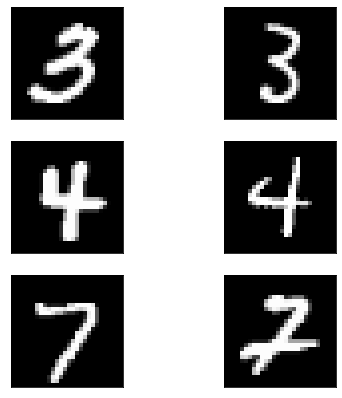

In [10]:
# Visualization of the sampled images
fig = plt.figure(figsize=(7,7))
ind = 1
for i in range(1, 4, 1):
    for j in range(1, 3, 1):
        fig.add_subplot(3,2,ind)
        show(np.squeeze(sample[ind-1]))
        plt.xticks([])
        plt.yticks([])
        ind+=1

In [11]:
#Questao 7a:
#-----------
#mnist = keras.datasets.mnist
#(x_train, y_train),(x_test, y_test) = mnist.load_data()
#x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
#x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
#x_train, x_test = x_train / 255.0, x_test / 255.0

model = keras.models.load_model('mnist_model.h5')
model_wo_sm = innvestigate.utils.keras.graph.model_wo_softmax(model)

#imagem = x_test[0:1]
#plot.imshow(imagem.squeeze(), cmap='gray', interpolation='nearest')

#analyzer = innvestigate.analyzer.LRPEpsilon(model=model_wo_sm, epsilon=1)
#analysis = analyzer.analyze(imagem)
#plt.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')

Importing classes and instantiating them

In [12]:
from innvestigate.analyzer.gradient_based import Gradient, SmoothGrad
from innvestigate.analyzer.deeptaylor import DeepTaylor
from innvestigate.analyzer.relevance_based.relevance_analyzer import LRPAlphaBeta, LRPEpsilon, BaselineLRPZ
#----------------------------
gradient    = Gradient(model=model_wo_sm)
smoothgrad  = SmoothGrad(model=model_wo_sm)
deeptaylor  = DeepTaylor(model=model_wo_sm)
lrpa        = LRPAlphaBeta(model=model_wo_sm, alpha=1, beta=0)
lrpe        = LRPEpsilon(model=model_wo_sm, epsilon=1)
lrpz        = BaselineLRPZ(model=model_wo_sm)

Function that plots analyzer outputs

In [13]:
def plot_analyzer(raw, analyzed, cmap='gray'):
    # Visualization of tha sampled images
    fig = plt.figure(figsize=(10,10))
    ind = 1
    for i in range(1, 7):
        for j in range(1, 3):
            if j==1:
                fig.add_subplot(6,2,(i-1)*2+j)
                plt.imshow(np.squeeze(raw[ind-1]), cmap='gray', interpolation = "none")
            if j==2:
                fig.add_subplot(6,2,(i-1)*2+j)
                plt.imshow(np.squeeze(analyzed[ind-1]), cmap=cmap, interpolation='nearest')
            plt.xticks([])
            plt.yticks([])
        ind+=1

## 7.3.1 Gradient

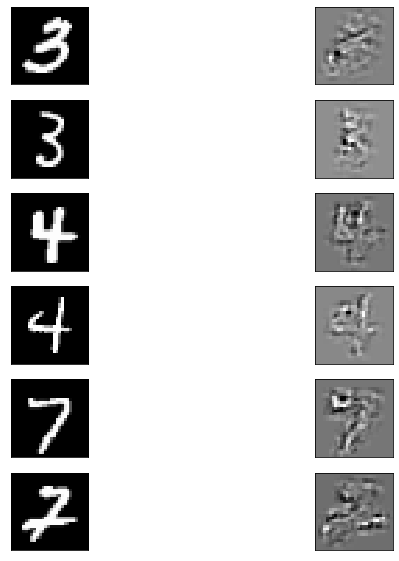

In [14]:
analysis_gradient = np.zeros((6,28,28,1))
for i, tensor in enumerate(sample):
    analysis_gradient[i] = gradient.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_gradient, cmap='gray')

Visualização baseada em função. Aqui podemos ver o gradiente do neurônio de saída com relação à entrada. É possível olhando apenas o gradiente ver o formato do dígito, ainda que distorcido e com bastante ruído.

## 7.3.2 SmoothGrad

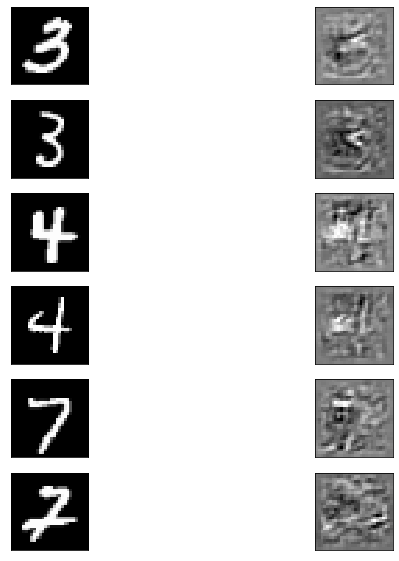

In [15]:
analysis_smoothgrad = np.zeros((6,28,28,1))
for i, tensor in enumerate(sample):
    analysis_smoothgrad[i] = smoothgrad.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_smoothgrad, cmap='gray')

Também baseada em função. O SmoothGrad calcula a média do gradiente em relação ao número de entradas com ruído adicional. Para alguns dígitos, ainda é possível ver o formato e relacionar com o número (ex dígito), outros fica um pouco mais ruidoso (ex: primeiro dígito 4 e segundo dígito 7).

## 7.3.3 DeepTaylor

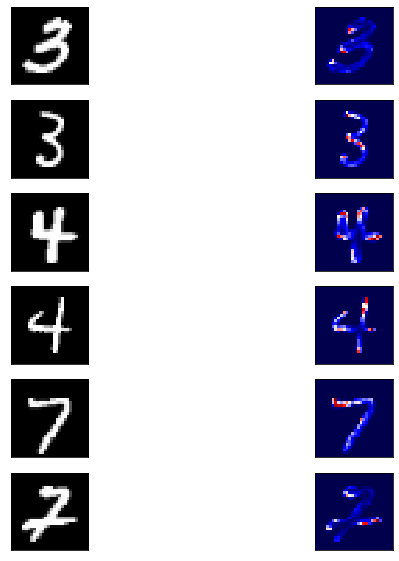

In [16]:
analysis_deeptaylor = np.zeros((6,28,28,1))
for i, tensor in enumerate(sample):
    analysis_deeptaylor[i] = deeptaylor.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_deeptaylor, cmap='seismic')

Método baseado em atribuição. Aqui, o DeepTaylor calcula para cada neurônio um ponto raiz, que é próximo da entrada, mas cujo valor de saída é 0, e usa essa diferença para estimar a atribuição de cada neurônio recursivamente. Os dígitos ficam visualmente bastante claros.

Os próximos três métodos são baseados em LRP (Layer-wise Relevance Propagation). Aqui, explora-se a propriedade de conservação de relevância recursivamente camada a camada, a partir da saída produzida.

## 7.3.4 LRPAlphaBeta

conditions:  
alpha >= 1  
alpha - beta = 1

alpha = 1  
beta = 0

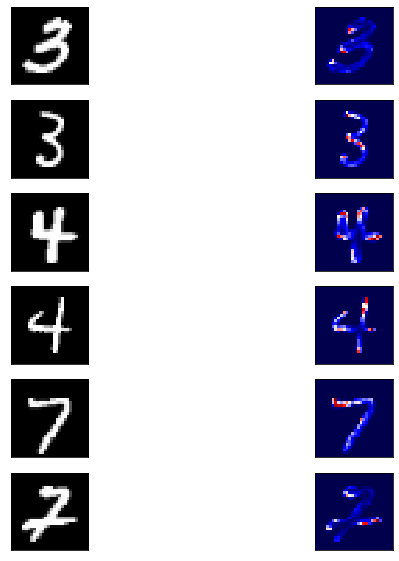

In [17]:
analysis_lrpa = np.zeros((6,28,28,1))
lrpa = LRPAlphaBeta(model=model_wo_sm, alpha=1, beta=0)
for i, tensor in enumerate(sample):
    analysis_lrpa[i] = lrpa.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_lrpa, cmap='seismic')

alpha = 2  
beta = 1

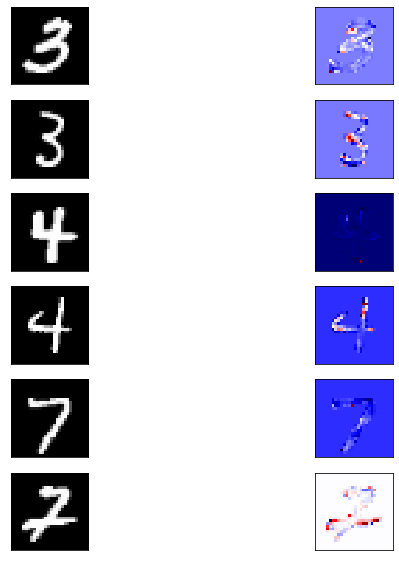

In [18]:
analysis_lrpa = np.zeros((6,28,28,1))
lrpa = LRPAlphaBeta(model=model_wo_sm, alpha=2, beta=1)
for i, tensor in enumerate(sample):
    analysis_lrpa[i] = lrpa.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_lrpa, cmap='seismic')

alpha = 1.5  
beta = 0.5

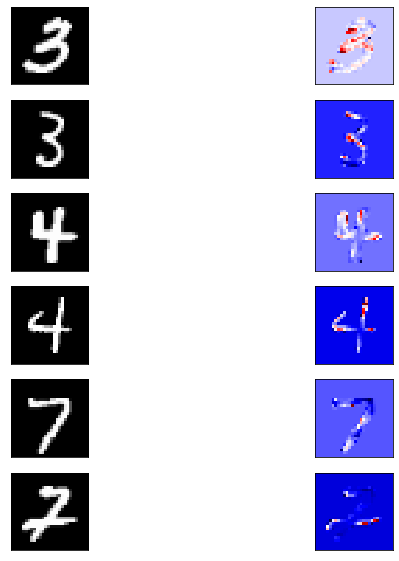

In [19]:
analysis_lrpa = np.zeros((6,28,28,1))
lrpa = LRPAlphaBeta(model=model_wo_sm, alpha=1.5, beta=0.5)
for i, tensor in enumerate(sample):
    analysis_lrpa[i] = lrpa.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_lrpa, cmap='seismic')

alpha = 1.2  
beta = 0.2

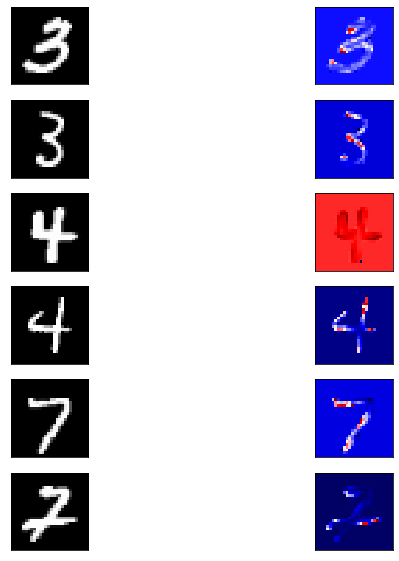

In [20]:
analysis_lrpa = np.zeros((6,28,28,1))
lrpa = LRPAlphaBeta(model=model_wo_sm, alpha=1.2, beta=0.2)
for i, tensor in enumerate(sample):
    analysis_lrpa[i] = lrpa.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_lrpa, cmap='seismic')

alpha = 1.3  
beta = 0.3


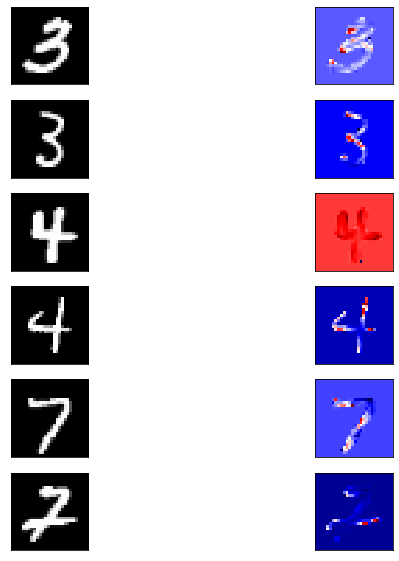

In [21]:
analysis_lrpa = np.zeros((6,28,28,1))
lrpa = LRPAlphaBeta(model=model_wo_sm, alpha=1.3, beta=0.3)
for i, tensor in enumerate(sample):
    analysis_lrpa[i] = lrpa.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_lrpa, cmap='seismic')

alpha = 1.25  
beta = 0.25


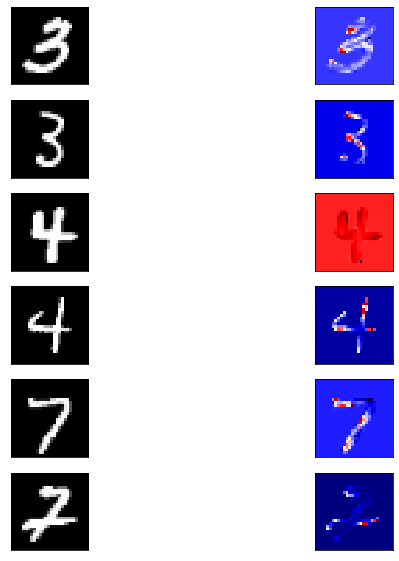

In [22]:
analysis_lrpa = np.zeros((6,28,28,1))
lrpa = LRPAlphaBeta(model=model_wo_sm, alpha=1.25, beta=0.25)
for i, tensor in enumerate(sample):
    analysis_lrpa[i] = lrpa.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_lrpa, cmap='seismic')

alpha = 3  
beta = 2

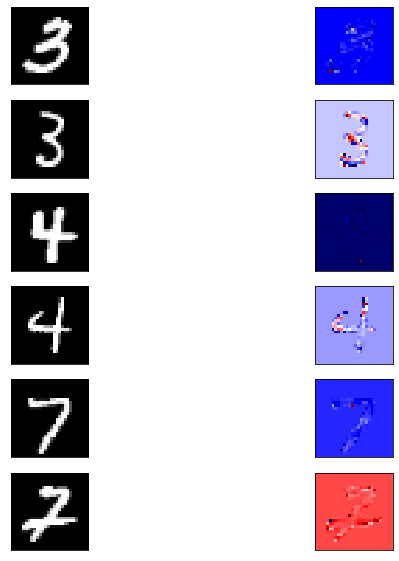

In [23]:
analysis_lrpa = np.zeros((6,28,28,1))
lrpa = LRPAlphaBeta(model=model_wo_sm, alpha=3, beta=2)
for i, tensor in enumerate(sample):
    analysis_lrpa[i] = lrpa.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_lrpa, cmap='seismic')

alpha = 5  
beta = 4


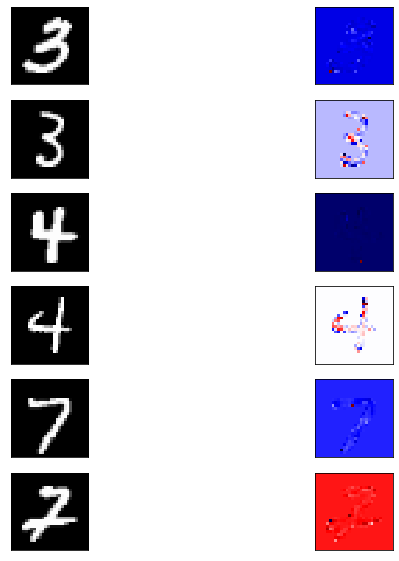

In [24]:
analysis_lrpa = np.zeros((6,28,28,1))
lrpa = LRPAlphaBeta(model=model_wo_sm, alpha=5, beta=4)
for i, tensor in enumerate(sample):
    analysis_lrpa[i] = lrpa.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_lrpa, cmap='seismic')

alpha = 10  
beta = 9

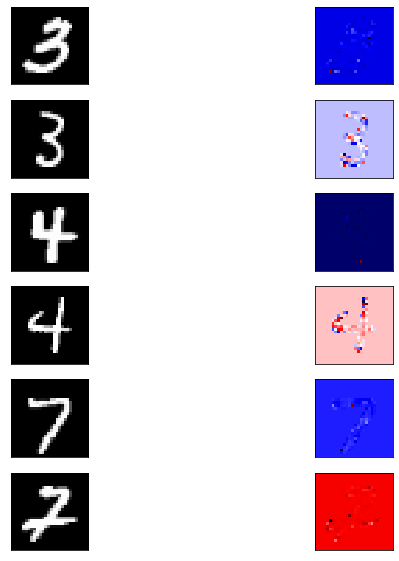

In [25]:
analysis_lrpa = np.zeros((6,28,28,1))
lrpa = LRPAlphaBeta(model=model_wo_sm, alpha=10, beta=9)
for i, tensor in enumerate(sample):
    analysis_lrpa[i] = lrpa.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_lrpa, cmap='seismic')

Um bom valor para alpha e beta pode ser 1.5 e 0.5, respectivamente, pois podemos ver as características mais acentuadas dos dígitos em pixels vermelho (ex: as pontas das curvas do dígito 3) e também os pixels que pouco ajudaram (ex: background em azul dos dígitos).

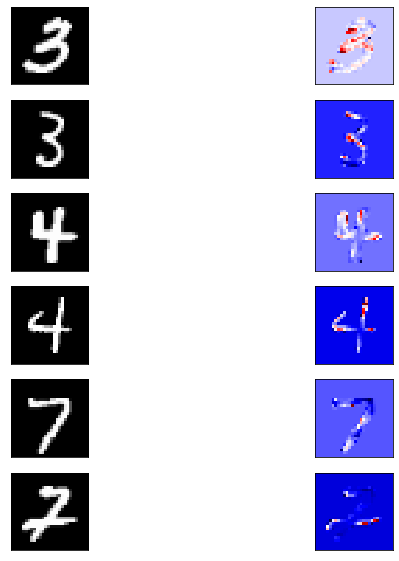

In [44]:
analysis_lrpa = np.zeros((6,28,28,1))
lrpa = LRPAlphaBeta(model=model_wo_sm, alpha=1.5, beta=0.5)
for i, tensor in enumerate(sample):
    analysis_lrpa[i] = lrpa.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_lrpa, cmap='seismic')

## 7.3.5 LRPEpsilon

epsilon = 1e-7

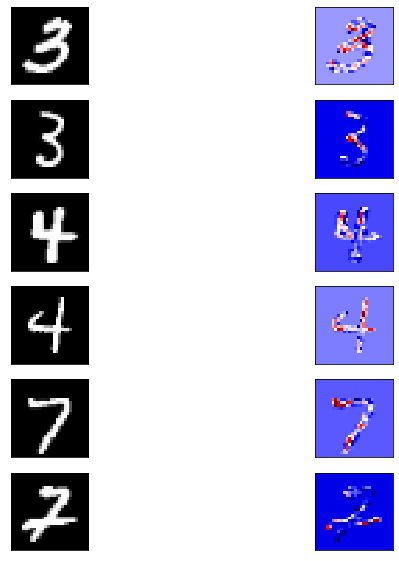

In [27]:
lrpe = LRPEpsilon(model=model_wo_sm, epsilon=1e-7)
analysis_lrpe = np.zeros((6,28,28,1))
for i, tensor in enumerate(sample):
    analysis_lrpe[i] = lrpe.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_lrpe, cmap='seismic')

epsilon = 1e-6

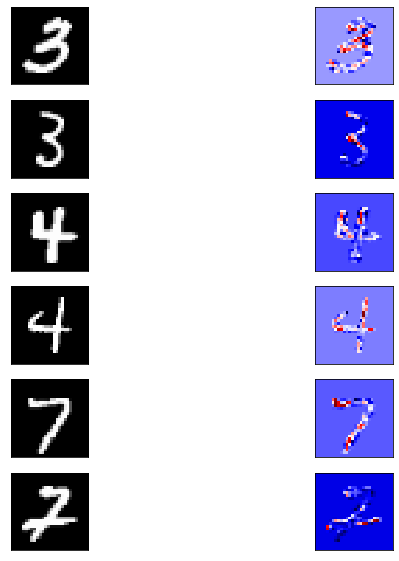

In [28]:
lrpe = LRPEpsilon(model=model_wo_sm, epsilon=1e-6)
analysis_lrpe = np.zeros((6,28,28,1))
for i, tensor in enumerate(sample):
    analysis_lrpe[i] = lrpe.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_lrpe, cmap='seismic')

epsilon = 1e-10

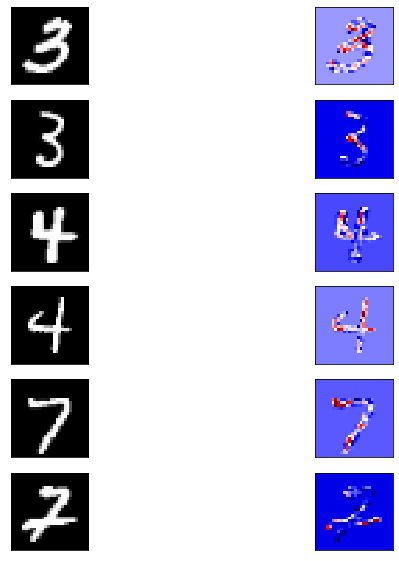

In [29]:
lrpe = LRPEpsilon(model=model_wo_sm, epsilon=1e-10)
analysis_lrpe = np.zeros((6,28,28,1))
for i, tensor in enumerate(sample):
    analysis_lrpe[i] = lrpe.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_lrpe, cmap='seismic')

epsilon = 1e-4

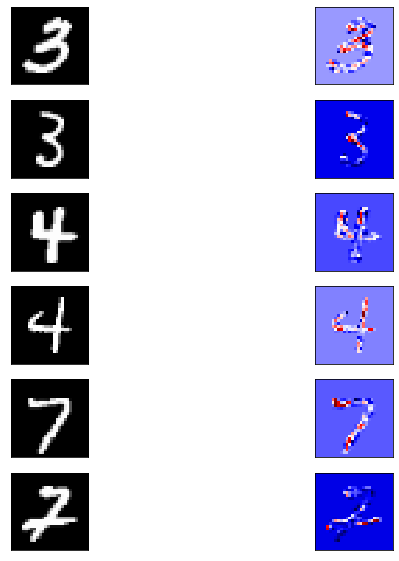

In [30]:
lrpe = LRPEpsilon(model=model_wo_sm, epsilon=1e-4)
analysis_lrpe = np.zeros((6,28,28,1))
for i, tensor in enumerate(sample):
    analysis_lrpe[i] = lrpe.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_lrpe, cmap='seismic')

epsilon = 1e-2

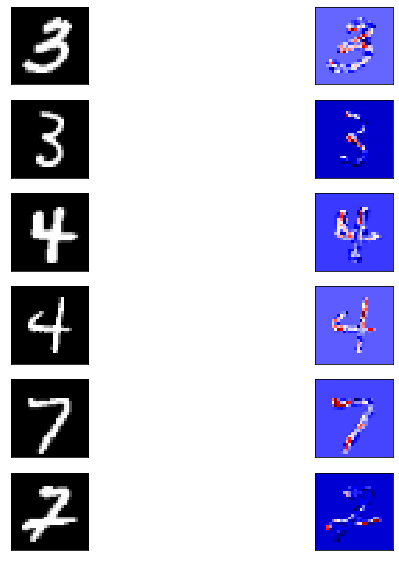

In [31]:
lrpe = LRPEpsilon(model=model_wo_sm, epsilon=1e-2)
analysis_lrpe = np.zeros((6,28,28,1))
for i, tensor in enumerate(sample):
    analysis_lrpe[i] = lrpe.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_lrpe, cmap='seismic')

epsilon = 1

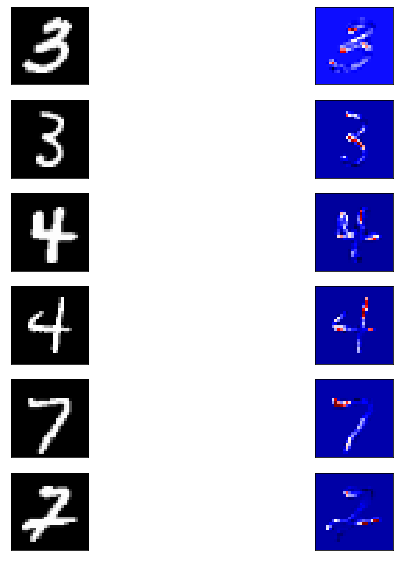

In [32]:
lrpe = LRPEpsilon(model=model_wo_sm, epsilon=1)
analysis_lrpe = np.zeros((6,28,28,1))
for i, tensor in enumerate(sample):
    analysis_lrpe[i] = lrpe.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_lrpe, cmap='seismic')

Um bom valor para epsilon pode ser o default, isto é, 1e-7. Com esse valor podemos ver as características mais acentuadas dos dígitos em pixels vermelho (ex: segmentos de reta do dígito 4) e também os pixels que pouco ajudaram em azul(ex: background).

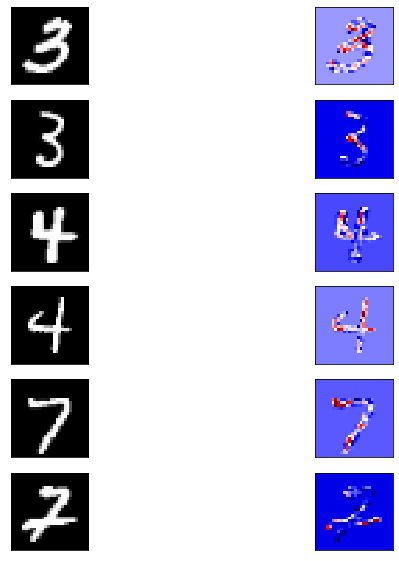

In [45]:
lrpe = LRPEpsilon(model=model_wo_sm, epsilon=1e-7)
analysis_lrpe = np.zeros((6,28,28,1))
for i, tensor in enumerate(sample):
    analysis_lrpe[i] = lrpe.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_lrpe, cmap='seismic')

## 7.3.6 LRPZ

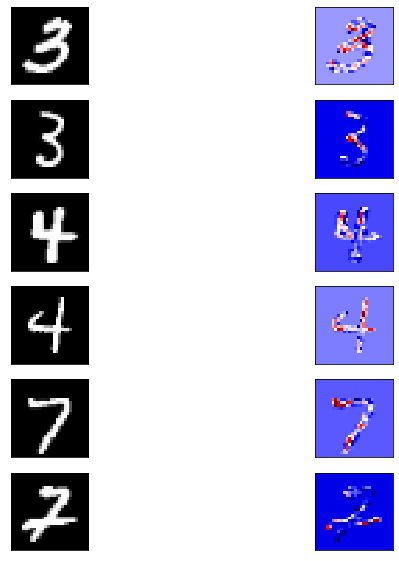

In [34]:
analysis_lrpz = np.zeros((6,28,28,1))
for i, tensor in enumerate(sample):
    analysis_lrpz[i] = lrpz.analyze(np.expand_dims(tensor, (0,-1)))
plot_analyzer(sample, analysis_lrpz, cmap='seismic')

Novamente podemos ver os pixels que ajudaram em vermelho e pixels não-relevantes em azul, como o fundo da imagem. Os pixels em branco nem ajudaram, nem atrapalharam, indicando que são segmentos de reta que podem aparecer em diversos dígitos no mesmo local.

## 7.3.7 Summary

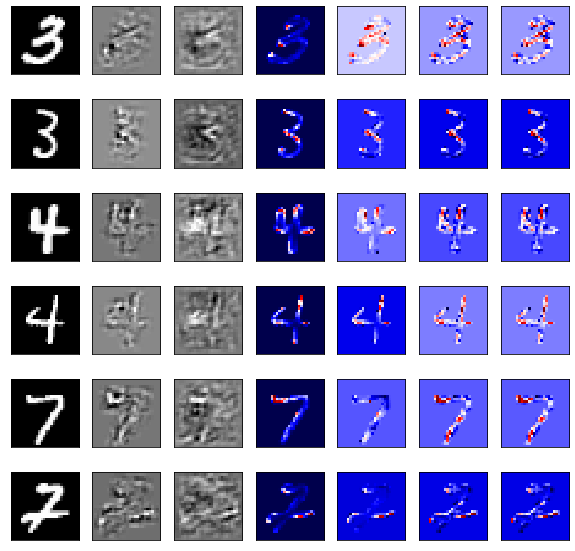

In [46]:
# Visualization of tha sampled images
fig = plt.figure(figsize=(10,10))
ind = 1
for i in range(1, 7):
    for j in range(1, 8):
        if j==1:
            fig.add_subplot(6,7,(i-1)*7+j)
            plt.imshow(np.squeeze(sample[ind-1]), cmap = 'gray', interpolation = "none")
        if j==2:
            fig.add_subplot(6,7,(i-1)*7+j)
            plt.imshow(np.squeeze(analysis_gradient[ind-1]), cmap='gray', interpolation='nearest')
        if j==3:
            fig.add_subplot(6,7,(i-1)*7+j)
            plt.imshow(np.squeeze(analysis_smoothgrad[ind-1]), cmap='gray', interpolation='nearest')
        if j==4:
            fig.add_subplot(6,7,(i-1)*7+j)
            plt.imshow(np.squeeze(analysis_deeptaylor[ind-1]), cmap='seismic', interpolation='nearest')
        if j==5:
            fig.add_subplot(6,7,(i-1)*7+j)
            plt.imshow(np.squeeze(analysis_lrpa[ind-1]), cmap='seismic', interpolation='nearest')
        if j==6:
            fig.add_subplot(6,7,(i-1)*7+j)
            plt.imshow(np.squeeze(analysis_lrpe[ind-1]), cmap='seismic', interpolation='nearest')
        if j==7:
            fig.add_subplot(6,7,(i-1)*7+j)
            plt.imshow(np.squeeze(analysis_lrpz[ind-1]), cmap='seismic', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
    ind+=1

# 7.4 Keras-vis (item 7b)

In [36]:
#Questao 7b:
#-----------
model = keras.models.load_model('mnist_model.h5')
# change last layer (softmax) with a linear layer
#layer_idx = utils.find_layer_idx(model, 'dense_2')
layer_idx = -1
model.layers[layer_idx].activation = keras.activations.linear
model = utils.apply_modifications(model)

## 7.4.1 Visualizing input that maximizes the output of class 0
(total variation = L-p norm = 0)

Iteration: 1, named_losses: [('ActivationMax Loss', 0.061430044), ('TV(2.0) Loss', 0.09180718)], overall loss: 0.1532372236251831
Iteration: 2, named_losses: [('ActivationMax Loss', 18.15419), ('TV(2.0) Loss', 530.05634)], overall loss: 548.2105102539062
Iteration: 3, named_losses: [('ActivationMax Loss', -119.157616), ('TV(2.0) Loss', 237.13167)], overall loss: 117.97405242919922
Iteration: 4, named_losses: [('ActivationMax Loss', -292.392), ('TV(2.0) Loss', 219.9908)], overall loss: -72.40119934082031
Iteration: 5, named_losses: [('ActivationMax Loss', -464.65778), ('TV(2.0) Loss', 226.42685)], overall loss: -238.23092651367188
Iteration: 6, named_losses: [('ActivationMax Loss', -609.7108), ('TV(2.0) Loss', 268.7609)], overall loss: -340.9499206542969
Iteration: 7, named_losses: [('ActivationMax Loss', -758.70013), ('TV(2.0) Loss', 304.31317)], overall loss: -454.386962890625
Iteration: 8, named_losses: [('ActivationMax Loss', -904.92883), ('TV(2.0) Loss', 362.5827)], overall loss: -

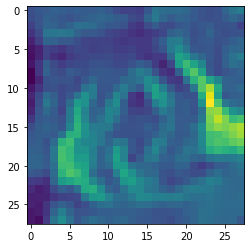

In [37]:
filter_idx = 0
img = visualize_activation(model, layer_idx,
    filter_indices=filter_idx, input_range=(0., 1.), verbose=True,
    max_iter=1000, tv_weight=10., lp_norm_weight=0.)
#plt.imshow(img.squeeze(), cmap='seismic', interpolation='nearest')
plt.imshow(img.squeeze(), interpolation='nearest')

## 7.4.2 Tunning total variation parameter

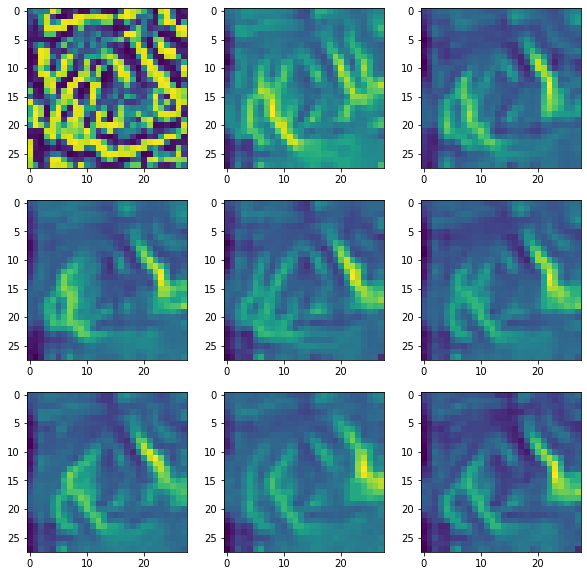

In [38]:
filter_idx = 0
fig = plt.figure(figsize=(10,10))
for i, tv_weight in enumerate([0, 2, 4, 6, 8, 10, 12, 14, 16]):
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                               tv_weight=tv_weight, lp_norm_weight=10.)
    #plt.figure()
    fig.add_subplot(3,3,i+1)
    plt.imshow(img[..., 0])

Total variation = 8 seems to be a good value (default=10)

## 7.4.3 Tunning L-p norm parameter

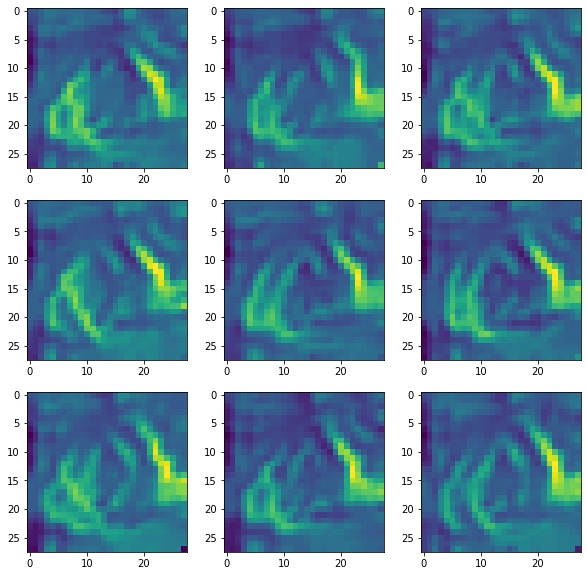

In [39]:
filter_idx = 0
fig = plt.figure(figsize=(10,10))
for i, lpnorm in enumerate([0, 2, 4, 6, 8, 10, 12, 14, 16]):
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                               tv_weight=8, lp_norm_weight=lpnorm)
    #plt.figure()
    fig.add_subplot(3,3,i+1)
    plt.imshow(img[..., 0])

L-p norm = 10 seems to be a good value (default=10)

## 7.4.4 Visualizing input that maximizes the output of class 0
(Tunned parameters: total variation = 8, L-p norm = 10)

Iteration: 1, named_losses: [('ActivationMax Loss', -0.09633272),
 ('L-6.0 Norm Loss', 0.019828636),
 ('TV(2.0) Loss', 0.07637952)], overall loss: -0.00012455880641937256
Iteration: 2, named_losses: [('ActivationMax Loss', -113.78901),
 ('L-6.0 Norm Loss', 0.17105371),
 ('TV(2.0) Loss', 395.83047)], overall loss: 282.2125244140625
Iteration: 3, named_losses: [('ActivationMax Loss', -348.45325),
 ('L-6.0 Norm Loss', 0.21981202),
 ('TV(2.0) Loss', 234.22142)], overall loss: -114.01200866699219
Iteration: 4, named_losses: [('ActivationMax Loss', -534.63025),
 ('L-6.0 Norm Loss', 0.24145707),
 ('TV(2.0) Loss', 253.14476)], overall loss: -281.2440185546875
Iteration: 5, named_losses: [('ActivationMax Loss', -722.05237),
 ('L-6.0 Norm Loss', 0.2726782),
 ('TV(2.0) Loss', 292.25186)], overall loss: -429.5278015136719
Iteration: 6, named_losses: [('ActivationMax Loss', -888.58484),
 ('L-6.0 Norm Loss', 0.30842963),
 ('TV(2.0) Loss', 335.333)], overall loss: -552.9434204101562
Iteration: 7, nam

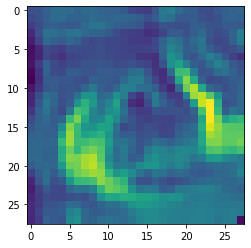

In [40]:
filter_idx = 0
img = visualize_activation(model, layer_idx,
    filter_indices=filter_idx, input_range=(0., 1.), verbose=True,
    max_iter=1000, tv_weight=8., lp_norm_weight=10.)
#plt.imshow(img.squeeze(), cmap='seismic', interpolation='nearest')
plt.imshow(img.squeeze(), interpolation='nearest')

## 7.4.5 Visualizing input that maximizes the output of each class

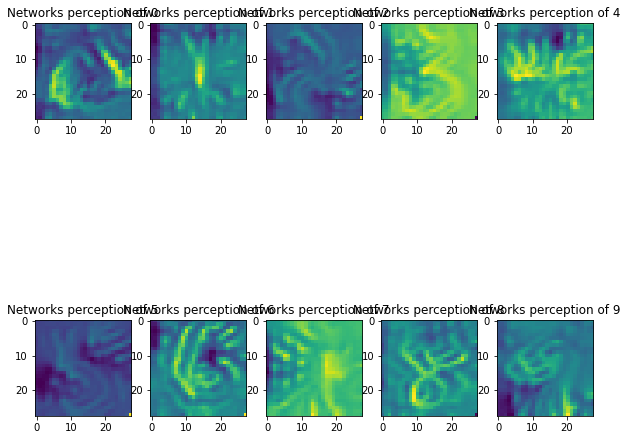

In [41]:
fig = plt.figure(figsize=(10,10))
for class_idx in np.arange(10):
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=class_idx, input_range=(0., 1.),
        max_iter=1000, tv_weight=8., lp_norm_weight=10.)
    #plt.figure()
    fig.add_subplot(2,5,class_idx+1)
    plt.title('Networks perception of {}'.format(class_idx))
    plt.imshow(img[..., 0])

Analisando as imagens obtidas, podemos claramente ver os padrões de entrada que maximizam a saída para determinado dígito. Alguns são bem claros e definidos (ex: dígito 6), outros menos claros (ex: dígito 5). Alterando os valores de total variation e L-p norm poderia deixar a imagem do dígito 5 mais clara, entretanto isso poderia piorar as demais (estamos adotando os mesmos parâmetros para todas classes). De qualquer mandeira, é possível enxergar a "barriga" do dígito 5, bem como sua base superior reta. Outro caso interessante é o dígito 1, que apresenta padrões com diversas angulações, variando desde menos 45 graus até 45 graus, indicando diferentes inclinações de escrita deste dígito. O dígito 8 também é curioso, pois apresenta quase que dois traços paralelos. Isso pode indicar duas formas de escrita, uma com o dígito mais largo e outra mais fina, translações do dígito, ora mais para direita, ora mais para esquerda, ou ainda duas inclinações possíveis (semelhante ao dígito 1).

# End of Notebook